## Setup

In [1]:
%load_ext autoreload
%autoreload 3
import sys

sys.path.append("..")

In [2]:
from nnsight.models.UnifiedTransformer import UnifiedTransformer
import torch.nn.functional as F
import torch as th
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import seaborn as sns
from transformers import AutoTokenizer
from pathlib import Path
from time import time
import itertools
from tqdm.autonotebook import tqdm

In [3]:
model = "croissantllm/CroissantLLMBase"
check_translation_performance = False
batch_size = 8
thinking_langs = ["en", "fr"]
langs = ["en", "fr", "de", "ru", "zh"]

In [7]:
BATCH_SIZE = batch_size
del batch_size
langs = np.array(langs)
from utils import add_model_to_transformer_lens
add_model_to_transformer_lens(model)
extra_langs = [lang for lang in langs if lang not in thinking_langs]
out_langs = {lang: np.array([l for l in extra_langs if l != lang]) for lang in langs}
tokenizer = AutoTokenizer.from_pretrained(model, padding_side="left")
tokenizer.pad_token_id = tokenizer.eos_token_id
nn_model = UnifiedTransformer(model, device="auto", processing=False) # , tokenizer=tokenizer)
# tokenizer = nn_model.tokenizer

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded pretrained model croissantllm/CroissantLLMBase into HookedTransformer


## Translation accuracy

In [7]:
if check_translation_performance:
    from exp_tools import get_translations, translation_prompts, logit_lens
    accuracies = np.ones((len(langs), len(langs)))
    translation_accuracies = {(lang, l) : 1 for lang, l in itertools.product(langs, langs)}
    probs = np.ones((len(langs), len(langs)))
    df = get_translations(langs)
    for i, input_lang in enumerate(langs):
        for j, output_lang in enumerate(langs):
            if input_lang == output_lang:
                continue
            prompts = translation_prompts(
                df, tokenizer, input_lang, output_lang, output_lang
            )
            success = 0
            str_prompts = [p.prompt for p in prompts]
            with th.no_grad():
                with nn_model.generate(
                    str_prompts,
                    max_new_tokens=1,
                    pad_token_id=tokenizer.eos_token_id,
                    do_sample=False,
                ) as tracer:
                    output = nn_model.generator.output.save()
            for ip, p in enumerate(prompts):
                if output[ip][-1].item() in p.target_tokens:
                    success += 1
            accuracies[i, j] = success / len(prompts)
            translation_accuracies[(input_lang, output_lang)] = accuracies[i, j]
            llens = logit_lens(nn_model, str_prompts)
            cum_probs = 0
            for ip, p in enumerate(prompts):
                cum_probs[i, j] += llens[ip, -1, p.target_tokens].sum()
            probs[i, j] = cum_probs / len(prompts)
            print(
                f"Accuracy {input_lang} -> {output_lang}:\nAcc: {accuracies[i, j]}\nProb: {probs[i, j]}"
            )

    sns.heatmap(
        accuracies, annot=True, cmap="YlGnBu", xticklabels=langs, yticklabels=langs
    )
    plt.title("Translation Accuracies")
    plt.xlabel("Output Language")
    plt.ylabel("Input Language")
    plt.show()
    sns.heatmap(probs, annot=True, cmap="YlGnBu", xticklabels=langs, yticklabels=langs)
    plt.title("Translation Mean Probabilities")
    plt.xlabel("Output Language")
    plt.ylabel("Input Language")
    plt.show()
    mean_accuracies = accuracies.mean(axis=1)
    sorted_indices = np.argsort(mean_accuracies)[::-1]
    langs = langs[sorted_indices]
    extra_langs = [lang for lang in langs if lang not in thinking_langs]
    for lang in langs:
        out_langs[lang] = sorted(out_langs[lang], key=lambda l: translation_accuracies[(lang, l)], reverse=True)


## Logit Lens plots

In [34]:
from utils import wr_translate
from exp_tools import load_lang


def get_translations(
    input_lang, langs, tokenizer=None, multi_token_only=False, single_token_only=False
):
    """
    Load translations from multiple languages and filter by token type if necessary
    """
    words = load_lang(input_lang)["word_translation"].values
    dic = {input_lang: words}
    for lang in langs:
        dic[lang] = [wr_translate(input_lang, lang, word) for word in tqdm(words)]
    df = pd.DataFrame(dic)
    df = df[df.map(lambda x: x != []).all(axis=1)]
    print(f"Found {len(df)} translations")
    return df


from exp_tools import translation_prompts, run_prompts
from utils import plot_ci


def translation_plot(
    input_lang, target_lang, latent_langs, batch_size=BATCH_SIZE, only_best=False
):
    if isinstance(latent_langs, str):
        latent_langs = [latent_langs]
    df = get_translations(input_lang, [target_lang, *latent_langs])
    prompts = translation_prompts(
        df,
        nn_model.tokenizer,
        input_lang,
        target_lang,
        latent_langs,
        only_best=only_best,
    )
    target_probs, latent_probs = run_prompts(nn_model, prompts, batch_size=batch_size)
    json_dic = {target_lang: target_probs.tolist()}
    for lang, probs in latent_probs.items():
        json_dic[lang] = probs.tolist()
    path = Path("results") / "translation"
    path.mkdir(parents=True, exist_ok=True)
    json_file = path / (
        "_".join([input_lang, target_lang, *latent_langs, str(int(time()))]) + ".json"
    )
    with open(json_file, "w") as f:
        json.dump(json_dic, f, indent=4)
    fig, ax = plt.subplots()
    colors = sns.color_palette("tab10", len(latent_langs) + 1)
    plot_ci(ax, target_probs, label=target_lang, color=colors[0])
    colors = {lang: color for lang, color in zip(latent_langs, colors[1:])}
    for latent_lang, probs in latent_probs.items():
        plot_ci(ax, probs, label=latent_lang, color=colors[latent_lang])
    ax.legend()
    ax.set_title(f"Translation from {input_lang} to {target_lang}")
    return fig, ax

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Translation from es to de'}>)

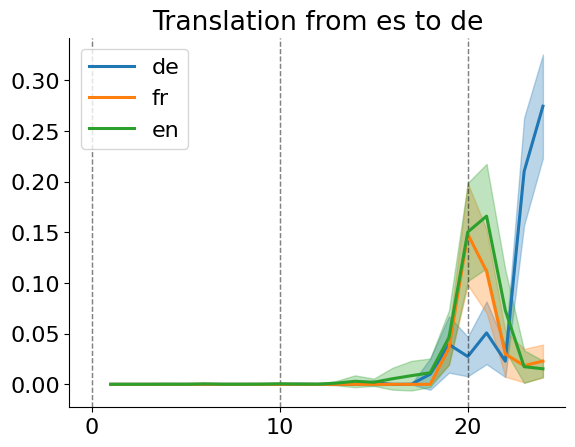

In [9]:
translation_plot("es", "de", ["fr", "en"])

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

Found 125 translations


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Translation from es to de'}>)

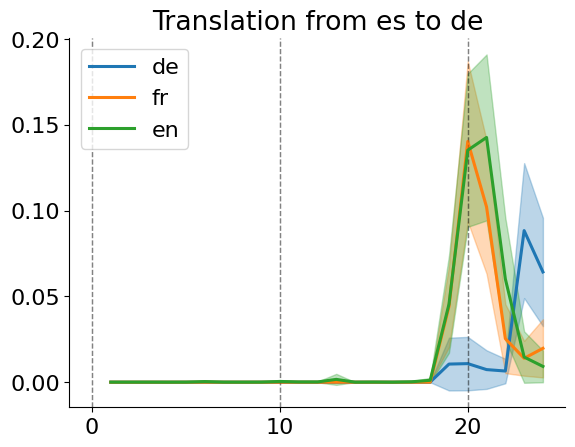

In [32]:
translation_plot("es", "de", ["fr", "en"], only_best=True)

In [29]:
# df = get_translations("es", ["de", "fr", "en"])
df = df[~(df[['de', 'fr', 'en']].map(lambda x: x == []).any(axis=1))]

for i, row in df.iterrows():
    if row["de"] == [] or row["fr"] == [] or row["en"] == []:
        print(row)

In [30]:
len(df.dropna())

125

In [21]:
row[1]["es"]

'libro'

In [36]:
translation_plot("en", "zh", ["fr"])

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

Found 132 translations


  0%|          | 0/132 [00:00<?, ?it/s]

SCSimplified Chinese 1


IndexError: list index out of range

### Thinking language translation

Found 109 translations


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Found 109 translations


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Found 104 translations


  0%|          | 0/104 [00:00<?, ?it/s]

KeyboardInterrupt: 

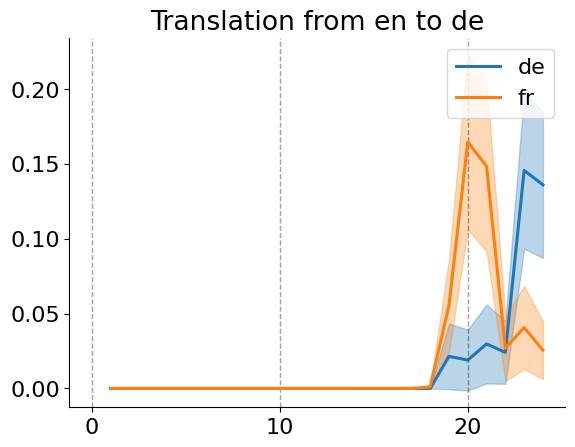

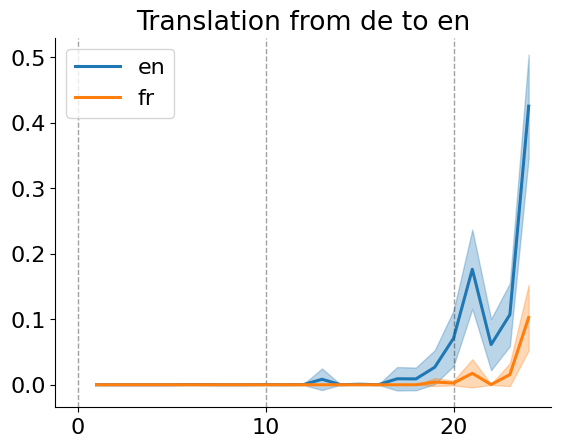

In [12]:
for lang in thinking_langs:
    for target_l in out_langs[lang]:
        th.cuda.empty_cache()
        fig, _  = translation_plot(lang, target_l, thinking_langs)
        plt.show()
        fig, _ = translation_plot(target_l, lang, [l for l in thinking_langs if l != lang])
        plt.show()

### Other language translation

In [ ]:
for lang in extra_langs:
    for target_l in out_langs[lang]:
        th.cuda.empty_cache()
        fig, _  = translation_plot(lang, target_l, thinking_langs)
        fig.show()